# Artificial Intelligence — Lab — Exercise 04

#### 29 September 2020

# Search Algorithm
---

Consider an autonomous mobile robot in a crowded environment that needs to find  an  efficient  path from  its  current  location S to  a  desired  location G.  As  an idealization of the situation, assume that the obstacles (whatever they may be) are  abstracted  by  polygons.  The  problem  now  reduces  to  finding  the shortest path between two points in a plane that has convex polygonal obstacles.

    (a) How do we formulate the state-space? How many states are there? How many paths are there to the goal? Think carefully to define a good state-space. Justify your decisions.
    
    
    (b) How do we define the actions in your formulation of the state-space?
    
        
    (c)  Formulate  this  problem  in  Python  by  subclassing  the  Problem  class  in “search.py” of the  reference implementation.  Take  extra  care  to  implement ACTIONS to find successor states of a given state.
        
     
    (d)  Define  your  evaluation  function  to  evaluate  the  goodness  or  badness  of  a state using an admissible heuristics function 
        
        
    (e) Create several instances (at least 100) of this problem by randomly generating planes with randomstart and goal points and random polygons as obstacles.
    
    
    (f) Solve all the instancesusing the following search strategies:
        _ Any basic strategy of your choice (DFS/BFS/IDS)
        _ Best-first greedy search
        _ A* search
        
        You may use the reference Python code to implement these search algorithms.
        
    
    (g)  Perform  an  empirical  analysis  in  terms  of  number  of  nodes  generated, expanded,  actual  time  taken,completeness,  optimality,  etc.  Which  algorithm performs better, in general, on all the instances?
  


In [1]:
import matplotlib.pyplot as plt
import random
import math
import time
import heapq
from collections import deque
from shapely.geometry import LineString,Polygon
import shapely.geometry as sg
import shapely.ops as so

plt.rcParams["figure.figsize"] = (10, 8)

<b>Problem</b> class was taken from [aima-python](https://github.com/aimacode/aima-python/blob/master/search.py)

In [2]:
class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError

In [3]:
class PolygonProblem(Problem):
    initial = None
    goal = None
    polygons = None
    point = None
    vertices = None
    adj_mat = None
    
    def __init__(self, initial, goal, polygons):
        self.initial = initial
        self.goal = goal
        self.polygons = polygons
        self.points = []
        
        self.points.append(self.initial)
    
        for polygon in self.polygons:
            for point in polygon:
                self.points.append(point)
    
        self.points.append(self.goal)
        
        self.vertices = len(self.points)
        self.adj_mat = self.make_adjacency_matrix()
        super().__init__(initial, goal)
    
    def is_edge(self, polygon, points):
        """Check if a given set of points form an edge in a polygon. """
        
        n = len(polygon)
        
        for i in range(n):
            if points[0] == polygon[i] and points[1] == polygon[(i+1)%n] \
            or points[1] == polygon[i] and points[0] == polygon[(i+1)%n]:
                return True
        return False
    
    def make_adjacency_matrix(self):
        """Convert the given graph into an adjacency matrix for state space representation. """
        
        adj = [[math.inf for j in range(self.vertices)] for i in range(self.vertices)]
        polys = [Polygon(poly) for poly in self.polygons]
        
        for i in range(self.vertices):
            for j in range(self.vertices):
                pt1 = self.points[i]
                pt2 = self.points[j]
                
                is_intersecting = False
                line = LineString([pt1, pt2])
                
                for k, polygon in enumerate(polys):
                    intersecting_points = list(polygon.intersection(line).coords)
                    
                    if len(intersecting_points) > 1:
                        if len(intersecting_points) == 2 \
                        and self.is_edge(self.polygons[k], intersecting_points):
                            continue
                        else:
                            is_intersecting = True
                            break
                
                if is_intersecting == False:
                    adj[i][j] = self.euclidean_distance(pt1, pt2)
        
        return adj
    
    def euclidean_distance(self, pt1, pt2):
        """Find the Euclidean distance between 2 given points. """
        
        return round(((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2 ) ** 0.5, 2)
    
    def find_next_states(self, source):
        """Find the set of next states from a given state. """
        
        return [dest for dest in range(self.vertices) \
                if self.adj_mat[source][dest] != math.inf and source != dest]
    
    def goal_test(self, state):
        """Check if current state is the goal state. """
        
        return self.points[state] == self.goal
    
    def edge_cost(self, state1, state2):
        """Find the edge cost between 2 states. """
        
        return self.adj_mat[state1][state2]
    
    def value(self, state):
        """Find the heuristic value of a state to the goal state. """
        
        point = self.points[state]
        return self.euclidean_distance(point, self.goal)
    
    def find_path(self, goal, ancestors):
        """Find the path traced to the goal state by a searching algorithm. """
        
        start = goal
        path = []
        
        while start:
            path.append(start)
            start = ancestors[start]
        path.append(0)
        
        path = path[::-1]
        return path
    
    def path_cost(self, path):
        """Find the total cost of traversing a given path. """
        
        return sum([self.edge_cost(path[i], path[i+1]) for i in range(len(path) - 1)])
    
    def BFS(self):
        """Perform BFS algorithm on the state space. """
        
        ancestors = dict()
        discovered = deque()
        explored = set()
        
        discovered.append(0)

        while discovered:
            state = discovered.popleft()
            
            for next_state in self.find_next_states(state):
                if self.goal_test(next_state):
                    ancestors[next_state] = state
                    path = self.find_path(next_state, ancestors)
                    return path, self.path_cost(path)
            
                elif next_state not in explored:
                    explored.add(next_state)
                    discovered.append(next_state)
                    ancestors[next_state] = state
        
        return None, math.inf
    
    def GBFS(self):
        """Perform GBFS algorithm on the state space. """
        
        ancestors = dict()
        discovered = []
        explored = set()
        
        discovered.append((self.value(0), 0))
        
        while discovered:
            value, state = heapq.heappop(discovered)
            
            if state in explored:
                continue
                
            explored.add(state)
            
            if self.goal_test(state):
                path = self.find_path(state, ancestors)
                return path, self.path_cost(path)
            
            for next_state in self.find_next_states(state):
                if next_state not in explored:
                    ancestors[next_state] = state
                    heapq.heappush(discovered, (self.value(next_state), next_state))
        
        return None, math.inf

In [4]:
polygons = [[(3, 4), (4, 4), (4, 5), (3, 5)],
            [(5, 4), (6, 3), (5, 1)],
            [(8, 2), (11, 2), (10, 4), (7, 5), (6, 4)],
            [(6, 7), (8, 7), (8, 5)],
            [(1, 7), (3, 8), (5, 7), (2, 5)],
            [(1, 2), (4, 0), (4, 3), (2, 3)]]

initial = (1, 1)
goal = (11, 7)
polys = [sg.Polygon(p) for p in polygons]

problem = PolygonProblem(initial, goal, polygons)

In [5]:
def plot_polygons(polys, title = "Initial Graph"):
    """Plot the polygons and the given start & goal node alone. """
    
    new_shape = so.cascaded_union(polys)
    fig, axes = plt.subplots()
    axes.set_aspect("equal", "datalim")
    
    for geom in new_shape.geoms:
        xs, ys = geom.exterior.xy
        axes.fill(xs, ys, alpha = 0.5, fc = 'r', ec = 'none')
    
    plt.scatter(*initial, label = "Start", c = 'blue', s = 100)
    plt.scatter(*goal, label = "Goal", c = 'green', s = 100)
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_path(polys, problem, path, title = "Graph with Solution Path"):
    
    new_shape = so.cascaded_union(polys)
    fig, axes = plt.subplots()
    axes.set_aspect("equal", "datalim")
    
    for geom in new_shape.geoms:
        xs, ys = geom.exterior.xy
        axes.fill(xs, ys, alpha = 0.5, fc = 'r', ec = 'none')
        
    for i in range(len(path)):
        if i != len(path) - 1:
            axes.plot([problem.points[path[i]][0], problem.points[path[i+1]][0]],
                      [problem.points[path[i]][1], problem.points[path[i+1]][1]])
            
        axes.scatter([problem.points[path[i]][0]], [problem.points[path[i]][1]], s = 50, c = 'red')
    
    plt.scatter(*initial, label = "Start", c = 'blue', s = 65)
    plt.scatter(*goal, label = "Goal", c = 'green', s = 65)
    plt.title(title)
    plt.legend()
    plt.show()

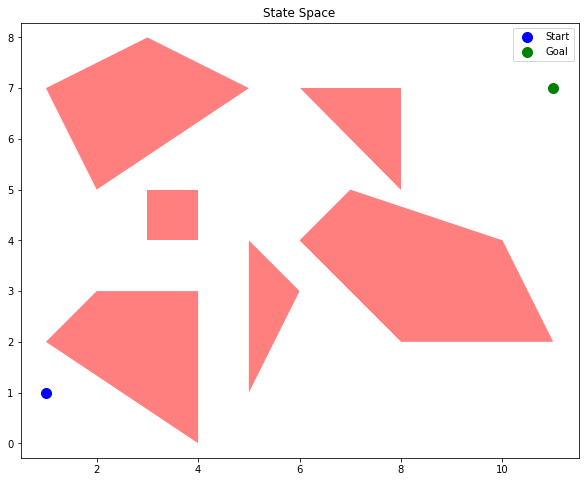

In [6]:
plot_polygons(polys, "State Space")

## Breadth First Search

In [7]:
%%timeit

problem.BFS()

26.7 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


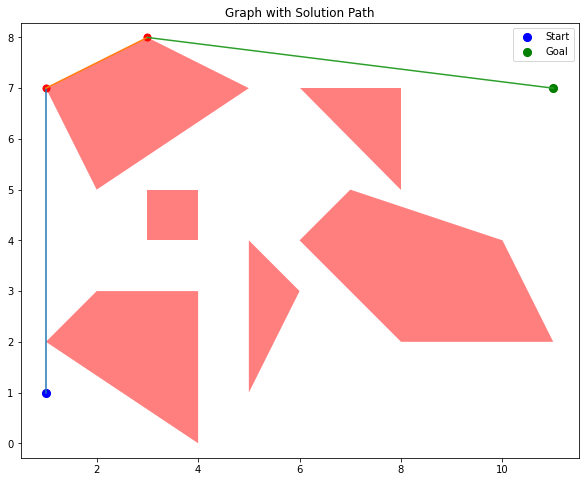

In [8]:
bfs_path, bfs_cost = problem.BFS()
plot_path(polys, problem, bfs_path)

In [9]:
traversed_points = []

for index in bfs_path:
    traversed_points.append(problem.points[index])

print("Path Found : ", traversed_points)

print("Path Cost of BFS:", round(bfs_cost, 2))

Path Found :  [(1, 1), (1, 7), (3, 8), (11, 7)]
Path Cost of BFS: 16.3


## Greedy Best-First Search

In [10]:
%%timeit

problem.GBFS()

37.8 µs ± 647 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


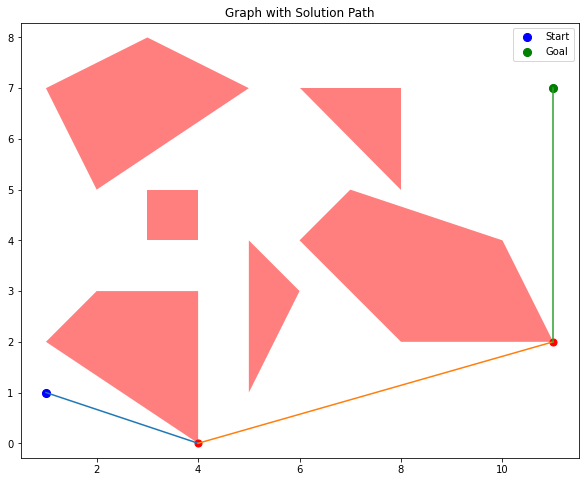

In [11]:
gbfs_path, gbfs_cost = problem.GBFS()
plot_path(polys, problem, gbfs_path)

In [12]:
traversed_points = []

for index in gbfs_path:
    traversed_points.append(problem.points[index])

print("Path Found : ", traversed_points)

print("Path Cost of GBFS:", round(gbfs_cost, 2))


Path Found :  [(1, 1), (4, 0), (11, 2), (11, 7)]
Path Cost of GBFS: 15.44


## Empirical Analysis

In [13]:
def test_algorithm(function, iterations):
    """Runs the above state space for 'iterations' times and notes the computation times. """
    
    runtimes = []
    
    for i in range(iterations):
        start = time.time()
        path, cost = function()
        end = time.time()
        
        runtimes.append((end - start) * 1000)
    
    return runtimes

In [14]:
%%time
bfs_runtimes = test_algorithm(problem.BFS, 1000)

Wall time: 30 ms


In [15]:
%%time
gbfs_runtimes = test_algorithm(problem.GBFS, 1000)

Wall time: 40.9 ms


GBFS has a longer running time than BFS due to increase in computational intensity.